# Data Exploration
---
Goals : 

0. Perform data analysis on current feature that available
1. Finding the correlation that might affecting the target feature
2. Investigate the effect of transformation + feature engineering on data to target feature

In [56]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

# Math
import numpy as np
import scipy as sp
import pandas as pd

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report, plot, plot_missing, plot_correlation

# Metrics
from sklearn import metrics

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

# CLustering
from sklearn.cluster import KMeans

# Dimension reductionality
from sklearn.decomposition import PCA

In [57]:
pd.set_option('display.max_columns', None)

tqdm.pandas()

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

# Showing all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Seaborn color palette
sns.set_palette('husl')

In [58]:
# === Load data ===

## EDIT THIS CODE
# =====================
filename = "../data/processed/dataset-supervised.pkl"
# =====================

df = pd.read_pickle(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95127 entries, 0 to 95126
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_pickup_point           95127 non-null  int64         
 1   customer_pickup_point_lat       95127 non-null  float64       
 2   customer_pickup_point_long      95127 non-null  float64       
 3   seller_pickup_point             95127 non-null  int64         
 4   seller_pickup_point_lat         95127 non-null  float64       
 5   seller_pickup_point_long        95127 non-null  float64       
 6   order_id                        95127 non-null  object        
 7   user_name                       95127 non-null  object        
 8   seller_id                       95127 non-null  object        
 9   total_item                      95127 non-null  int64         
 10  total_unique_item               95127 non-null  int64         
 11  pa

In [59]:
# === Lets categorize data ===
to_drop = [ 
    # Identifier feature
    "order_id",
    "user_name",
    "seller_id",
]

categorical_cols = [
    "order_is_weekend",
    "order_approved_is_weekend",
    "pickup_limit_is_weekend",
    
    "order_daytime",
    "order_approved_daytime"
]

geo_cols = [
    # Used only for more feature engineering + eda
    "seller_lat",
    "seller_long",
    "seller_pickup_point",
    "seller_pickup_point_lat",
    "seller_pickup_point_long",
    
    "customer_lat",
    "customer_long",
    "customer_pickup_point",
    "customer_pickup_point_lat",
    "customer_pickup_point_long",
]

numerical_cols = [
    
    # Order details
    "aov",
    "total_price",
    "shipping_cost",
    "total_item",
    
    # Distance cols
    "original_distance",
    "pickup_distance",
    "shipping_distance",
    "delivering_distance",
    
    # Duration cols 
    "wd_approved_interval",
    "wd_pickup_limit_interval",
    
    # Product details
    "package_volume_cm3",
    "package_weight_g",
    
    "product_volume_cm3_per_item",
    "product_weight_g_per_item",
    
    # For evaluation
    "wd_estimated_delivery_interval"
]

target = "wd_actual_delivery_interval"

### Removing Outlier

This steps is important because our data is filled with many outliers

Use : IQR Method

In [60]:
# Outlier -> IN this case, it happens because of natural outliers...
data = df.wd_actual_delivery_interval.values

# First quartile (Q1)
Q1 = np.percentile(data, 25, interpolation = 'midpoint')
  
# Third quartile (Q3)
Q3 = np.percentile(data, 75, interpolation = 'midpoint')
  
# Interquaritle range (IQR)
IQR = Q3 - Q1
min_bound = Q1 - 1.5 * IQR
max_bound = Q3 + 1.5 * IQR
print(f"IQR : {IQR}")
print(f"Lower bound : {min_bound}")
print(f"Upper bound : {max_bound}")

# Tbh, we should use IQR * 1.5 to find upper bound and lower bound, but in here case, we should use 1 month as the outlier base
non_outlier = df.loc[df[target] <= max_bound] # since that lower bound < 0, we can ignore the lower bound 
outlier = df.loc[df[target] >= max_bound]

df = non_outlier.copy()

IQR : 9.0
Lower bound : -7.5
Upper bound : 28.5


### Deep Dive Geolocation Feature

In [61]:
# === Get each seller pickup points ===
seller_pickup_points = df \
    .groupby(['seller_pickup_point']).agg(
        seller_pickup_point_lat = ('seller_pickup_point_lat', 'first'),
        seller_pickup_point_long = ('seller_pickup_point_long', 'first'),
        pop = ('seller_pickup_point', 'size')
    ).reset_index()

# === Get each customer pickup points ===
customer_pickup_points = df \
    .groupby(['customer_pickup_point']).agg(
        customer_pickup_point_lat = ('customer_pickup_point_lat', 'first'),
        customer_pickup_point_long = ('customer_pickup_point_long', 'first'),
        pop = ('customer_pickup_point', 'size')
    ).reset_index()

<AxesSubplot:xlabel='seller_pickup_point_lat', ylabel='seller_pickup_point_long'>

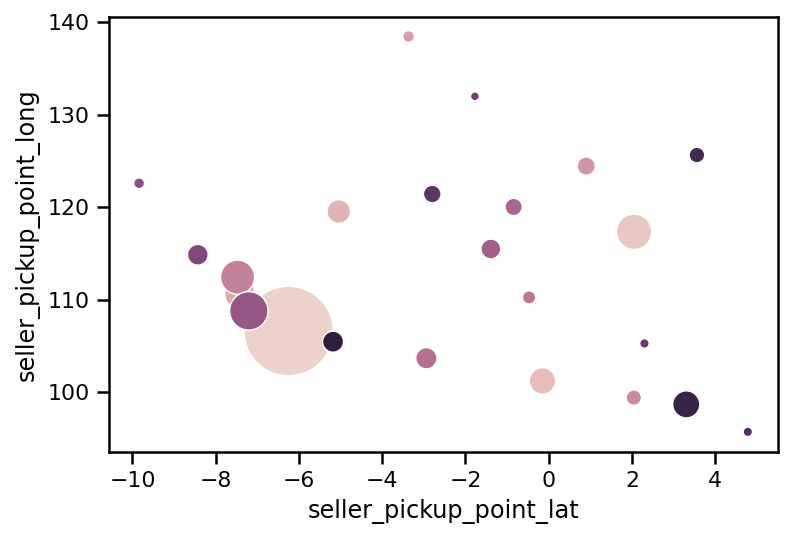

In [62]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=seller_pickup_points, x="seller_pickup_point_lat", y="seller_pickup_point_long", size="pop", hue="seller_pickup_point", legend=False, sizes=(20, 2000))

<AxesSubplot:xlabel='customer_pickup_point_lat', ylabel='customer_pickup_point_long'>

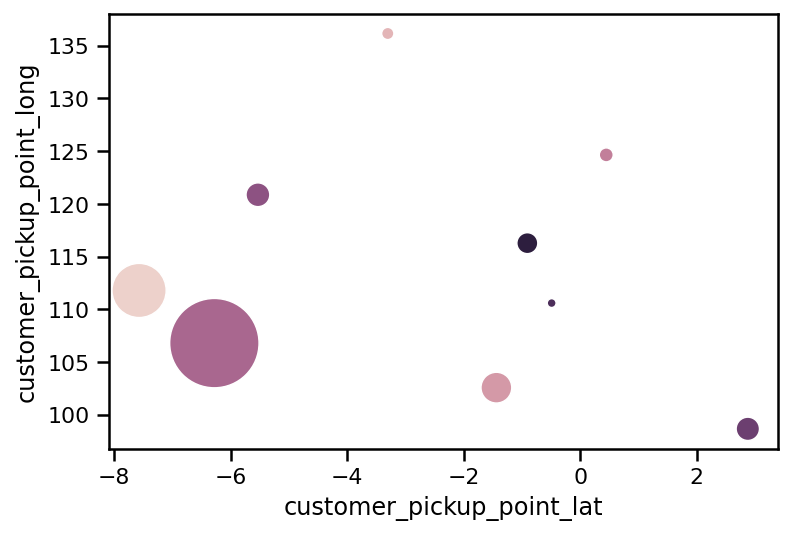

In [63]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=customer_pickup_points, x="customer_pickup_point_lat", y="customer_pickup_point_long", size="pop", hue="customer_pickup_point", legend=False, sizes=(20, 2000))

### Deep Dive Categorical feature

In [64]:
from pprint import pprint
pprint(categorical_cols)

['order_is_weekend',
 'order_approved_is_weekend',
 'pickup_limit_is_weekend',
 'order_daytime',
 'order_approved_daytime']


<AxesSubplot:xlabel='order_daytime', ylabel='wd_actual_delivery_interval'>

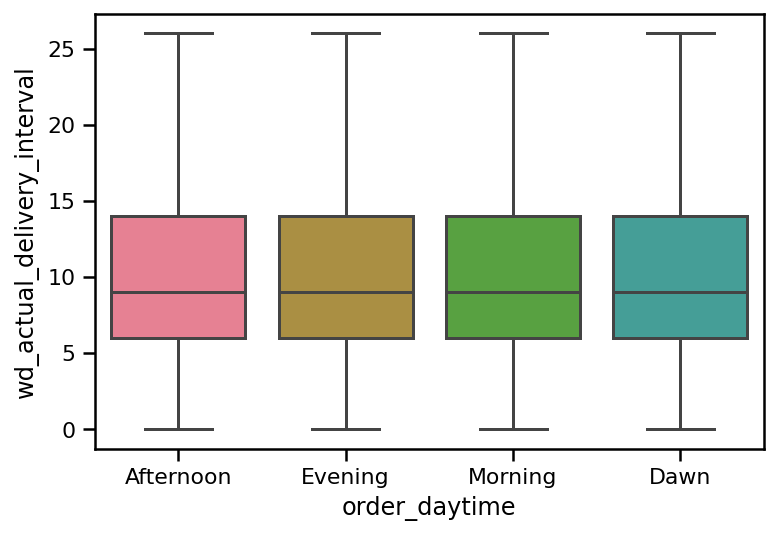

In [65]:
sns.boxplot(data=df, x="order_daytime", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='order_is_weekend', ylabel='wd_actual_delivery_interval'>

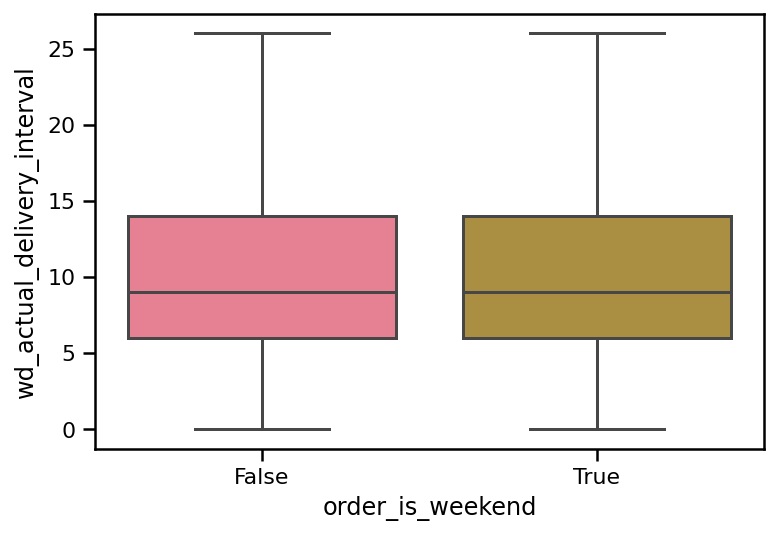

In [66]:
sns.boxplot(data=df, x="order_is_weekend", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='order_approved_daytime', ylabel='wd_actual_delivery_interval'>

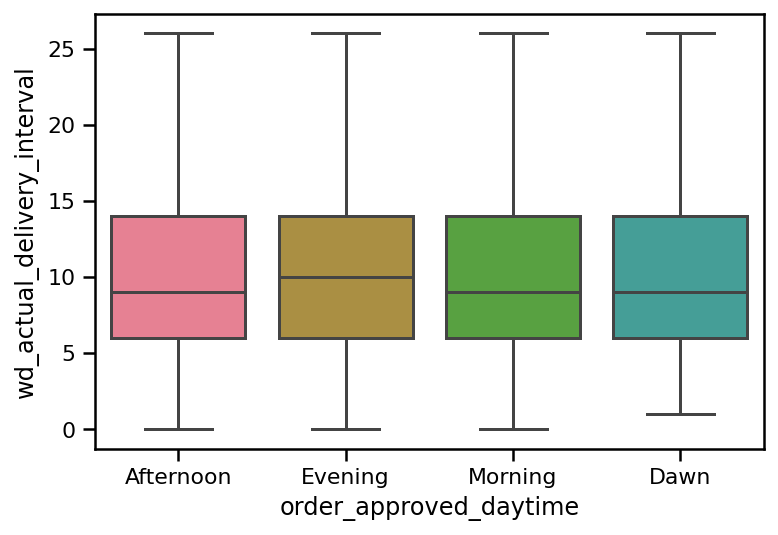

In [67]:
sns.boxplot(data=df, x="order_approved_daytime", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='order_approved_is_weekend', ylabel='wd_actual_delivery_interval'>

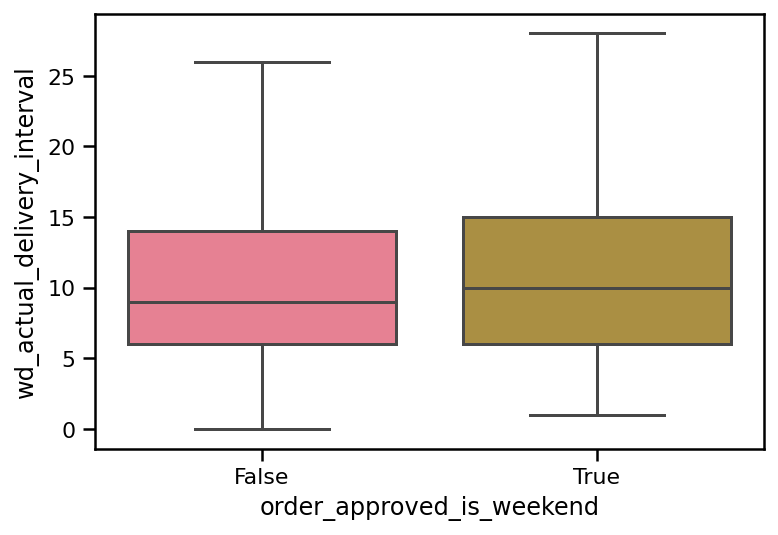

In [68]:
sns.boxplot(data=df, x="order_approved_is_weekend", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='pickup_limit_is_weekend', ylabel='wd_actual_delivery_interval'>

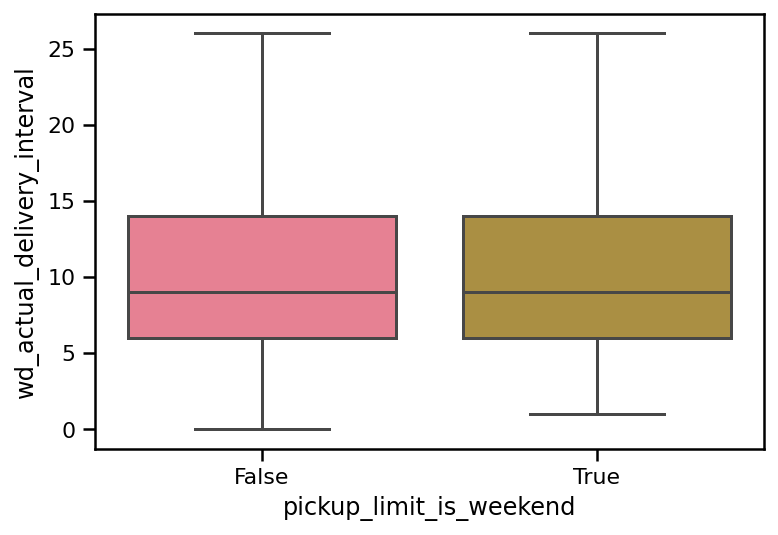

In [69]:
sns.boxplot(data=df, x="pickup_limit_is_weekend", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='order_is_weekend', ylabel='count'>

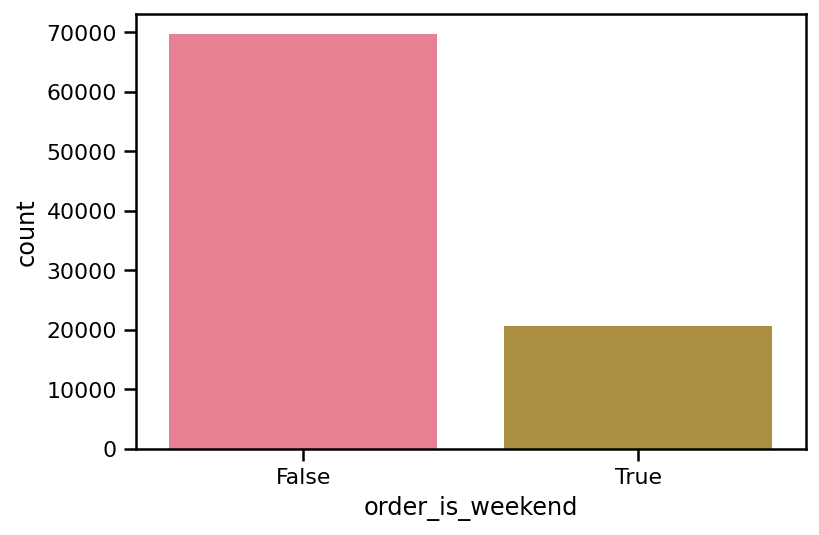

In [70]:
sns.countplot(df.order_is_weekend)

<AxesSubplot:xlabel='order_daytime', ylabel='count'>

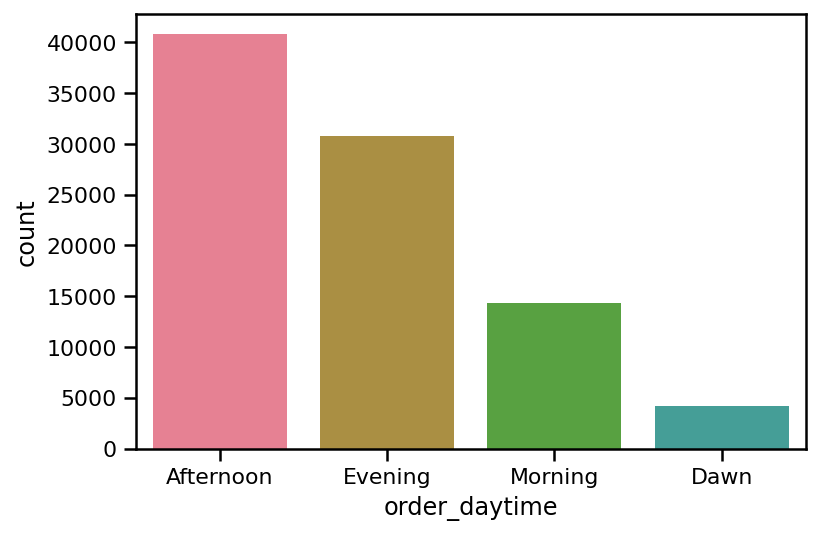

In [71]:
sns.countplot(df.order_daytime)

<AxesSubplot:xlabel='order_approved_is_weekend', ylabel='count'>

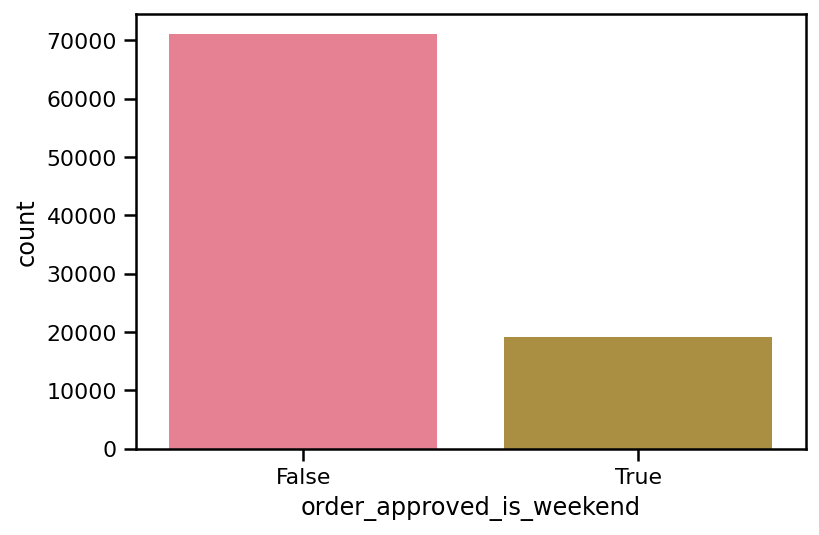

In [72]:
sns.countplot(df.order_approved_is_weekend)

<AxesSubplot:xlabel='order_approved_daytime', ylabel='count'>

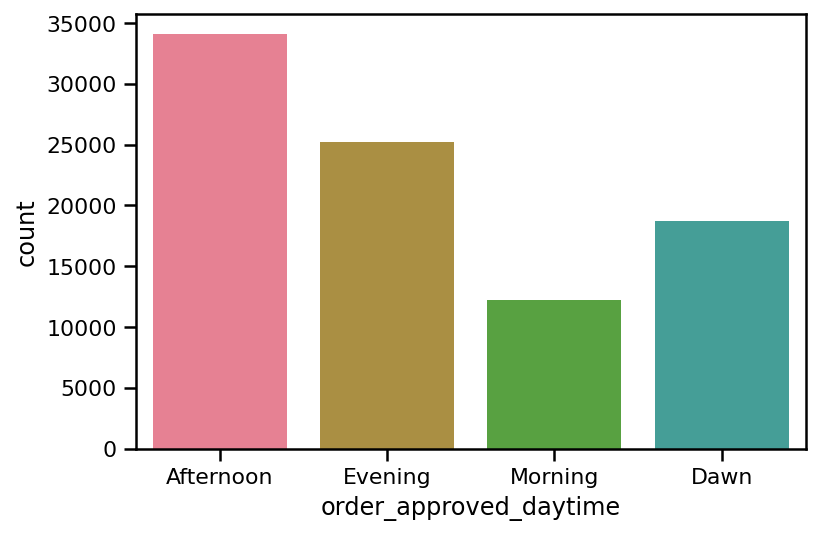

In [73]:
sns.countplot(df.order_approved_daytime)

<AxesSubplot:xlabel='pickup_limit_is_weekend', ylabel='count'>

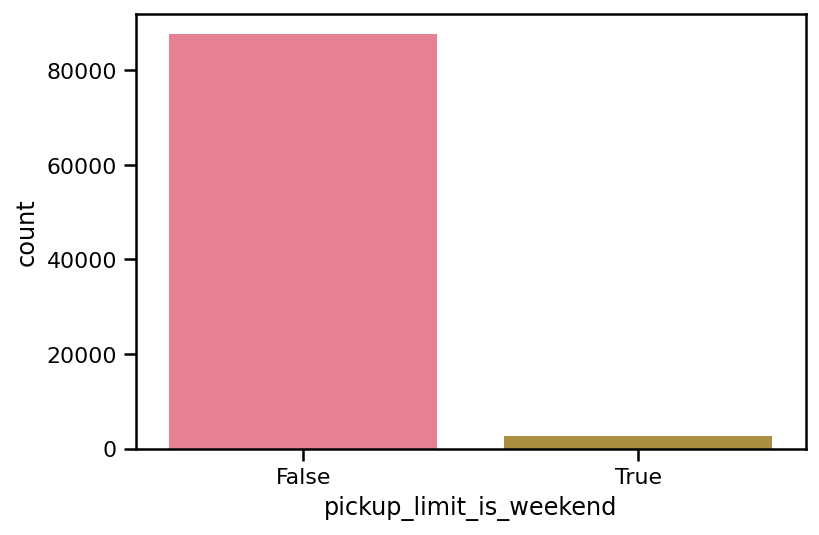

In [74]:
sns.countplot(df.pickup_limit_is_weekend)

# Practically useless -> but actually interesting, because it means that pickup limit most likely never weekend...

### Deep Dive Numerical Feature

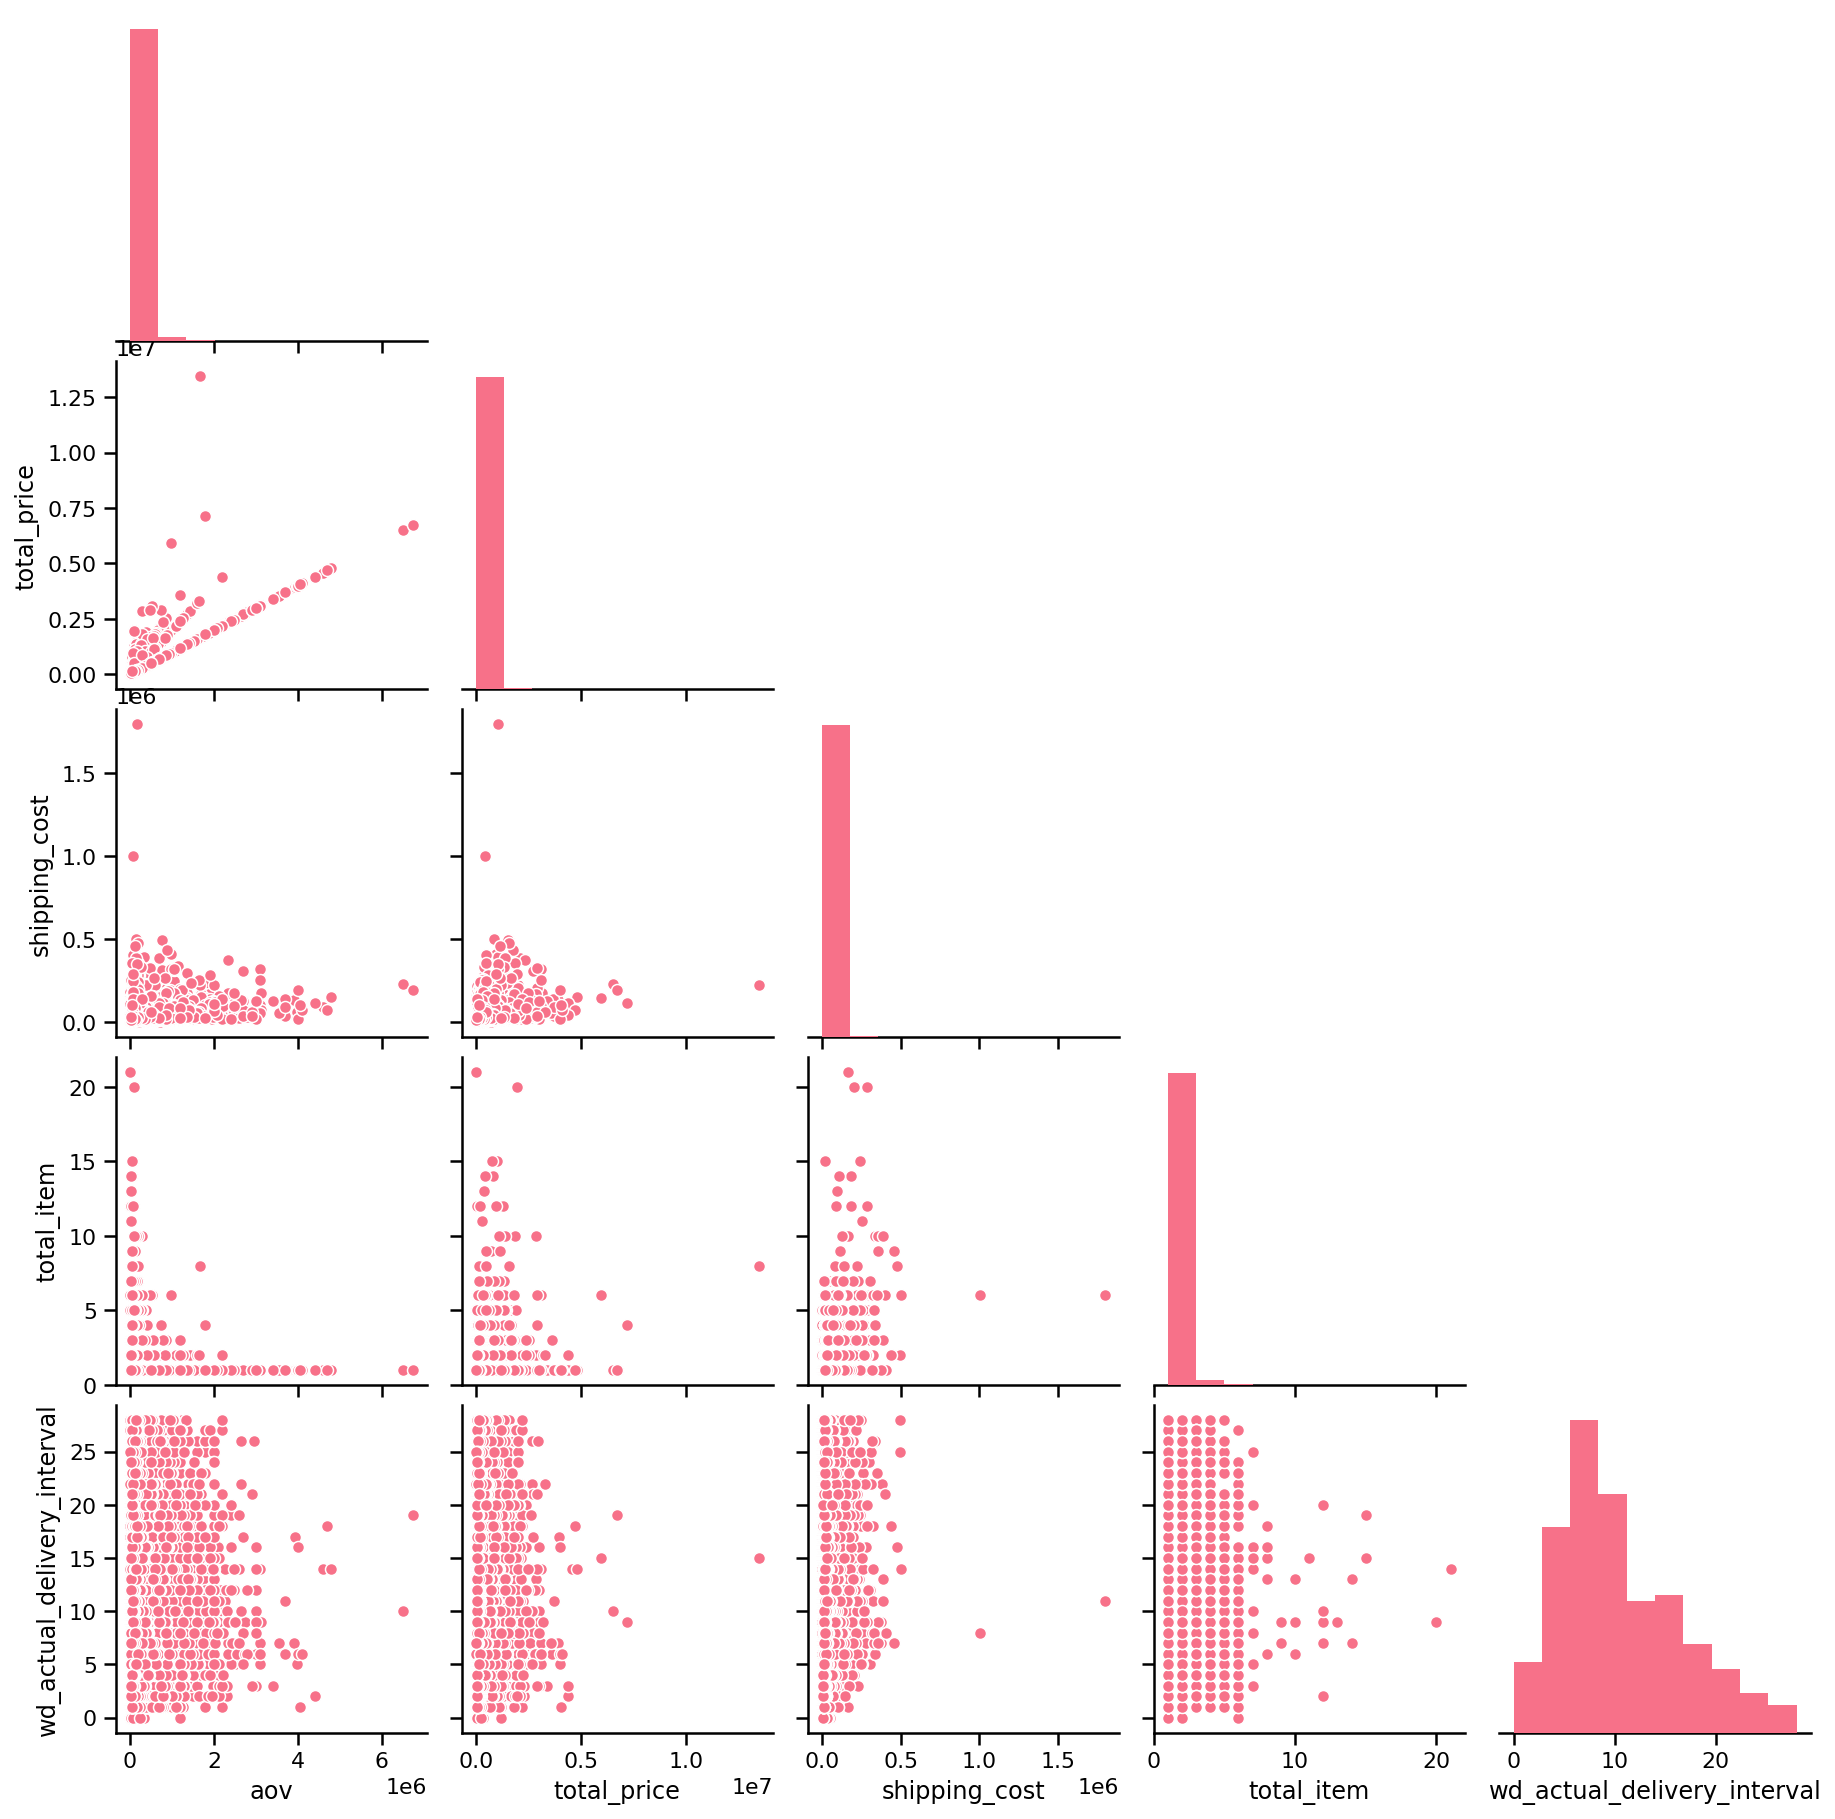

In [75]:
order_cols = [
    # Order details
    "aov",
    "total_price",
    "shipping_cost",
    "total_item",
    target
]

sns.pairplot(data=df, vars = order_cols, corner=True)

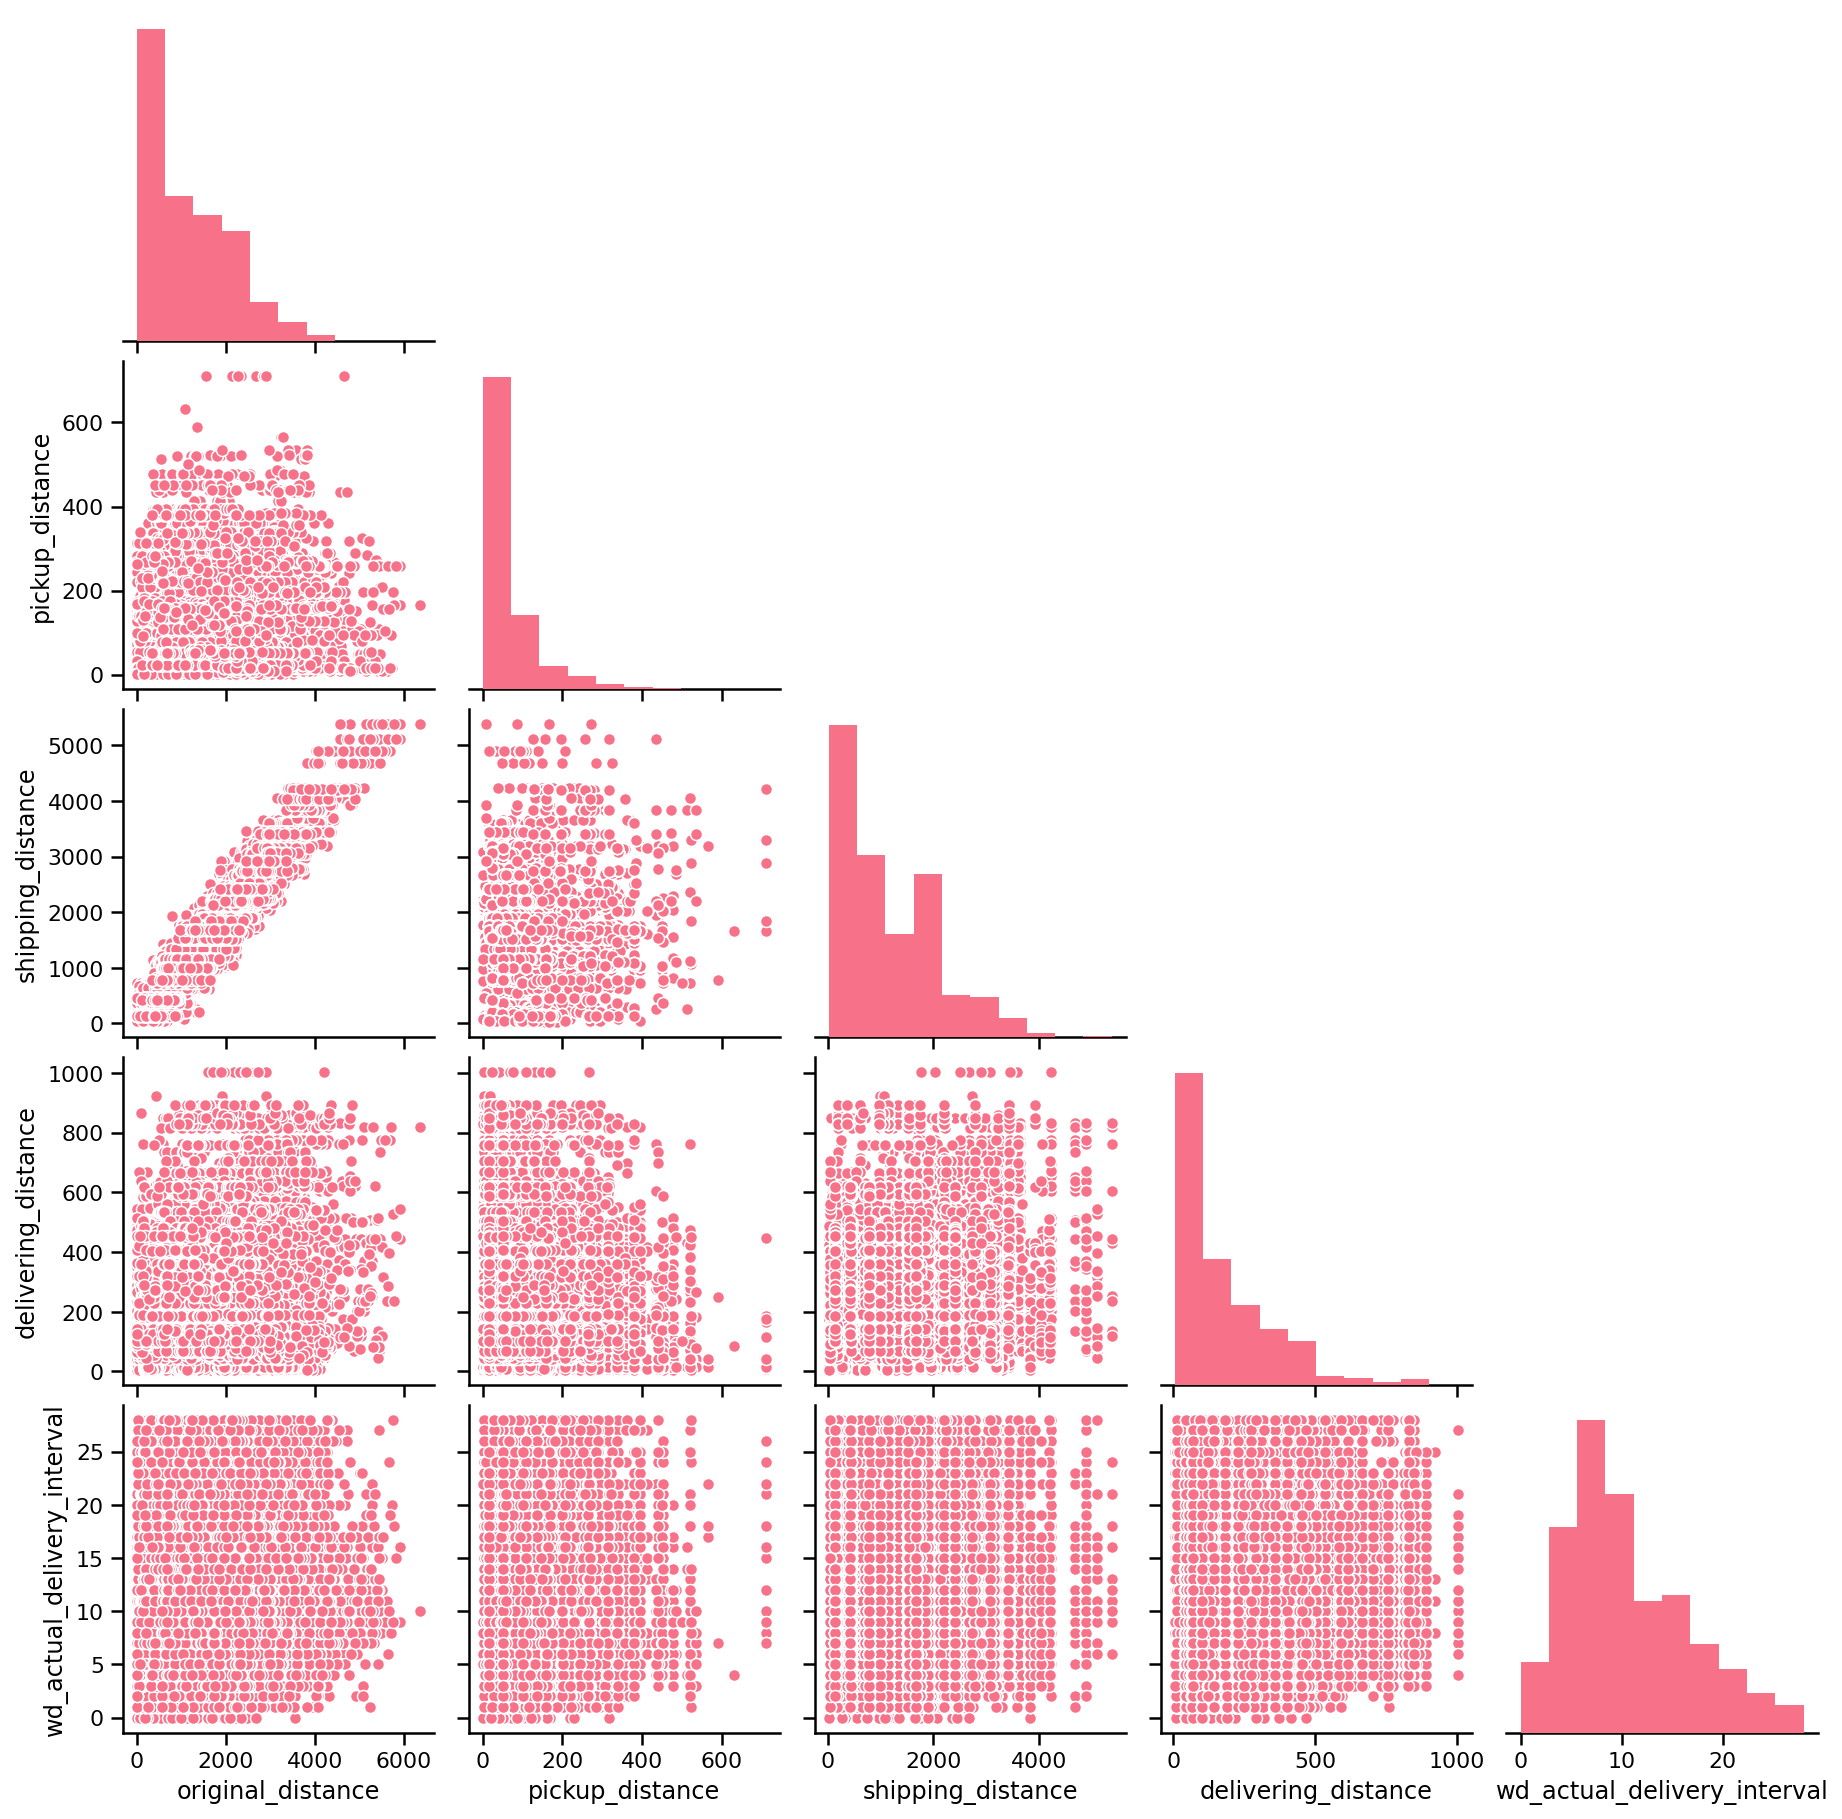

In [76]:
distance_cols = [
    # Distance cols
    "original_distance",
    "pickup_distance",
    "shipping_distance",
    "delivering_distance",
    target
]

sns.pairplot(data=df, vars = distance_cols, corner=True)

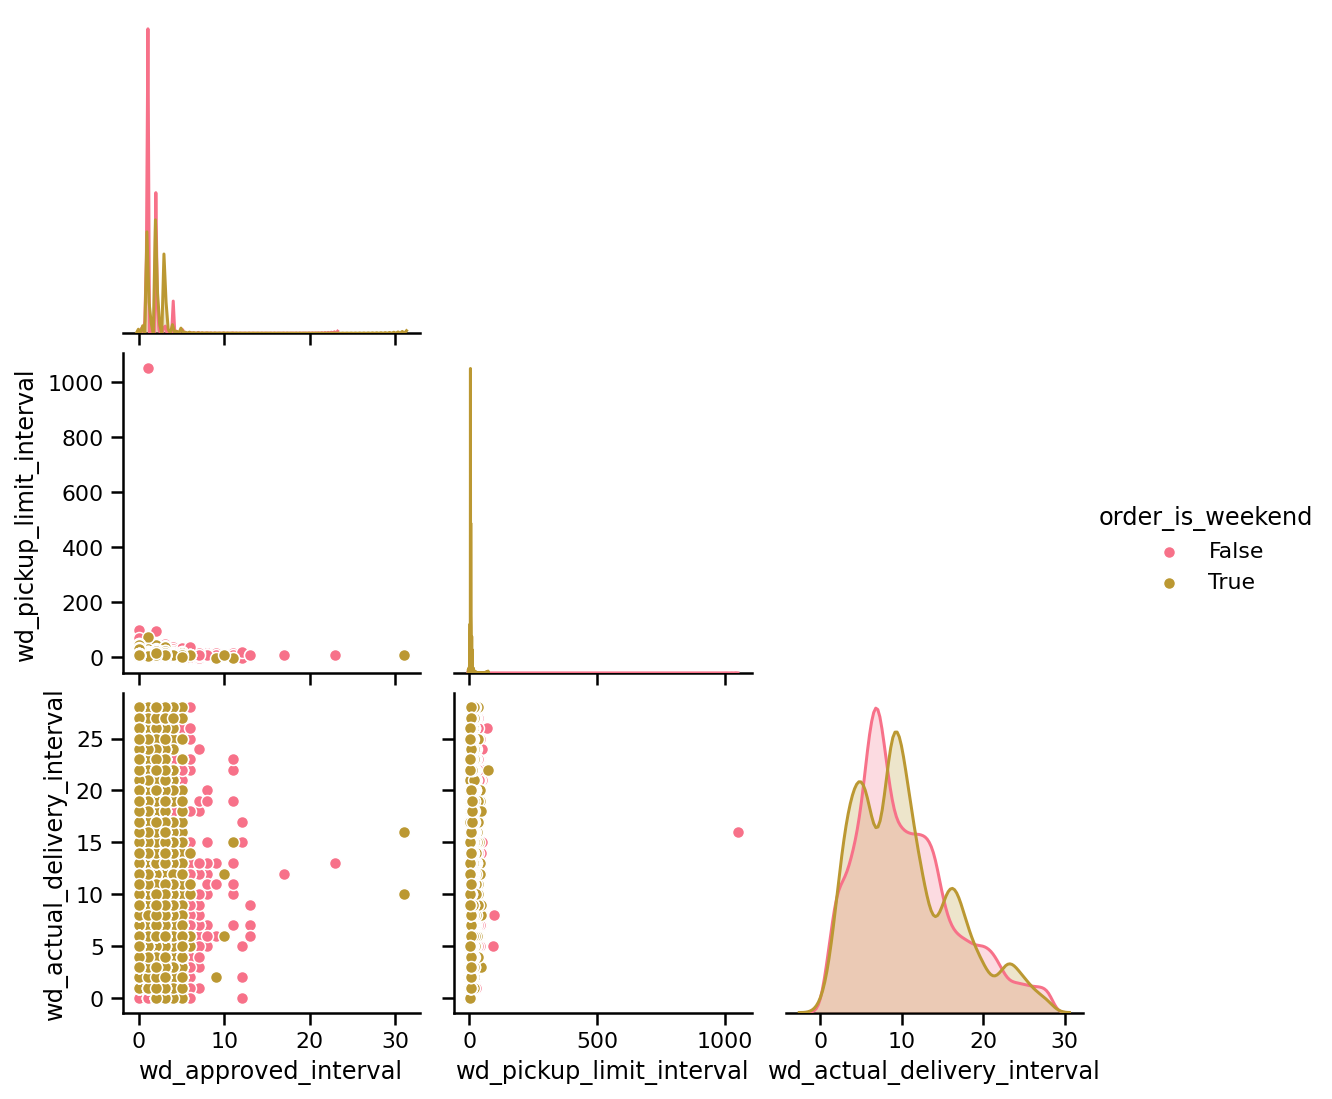

In [77]:
# Duration based

duration_cols = [
    # Duration cols 
    "wd_approved_interval",
    "wd_pickup_limit_interval",
    
    # Target
    target,
]

sns.pairplot(data=df, vars = duration_cols, hue="order_is_weekend", corner=True)

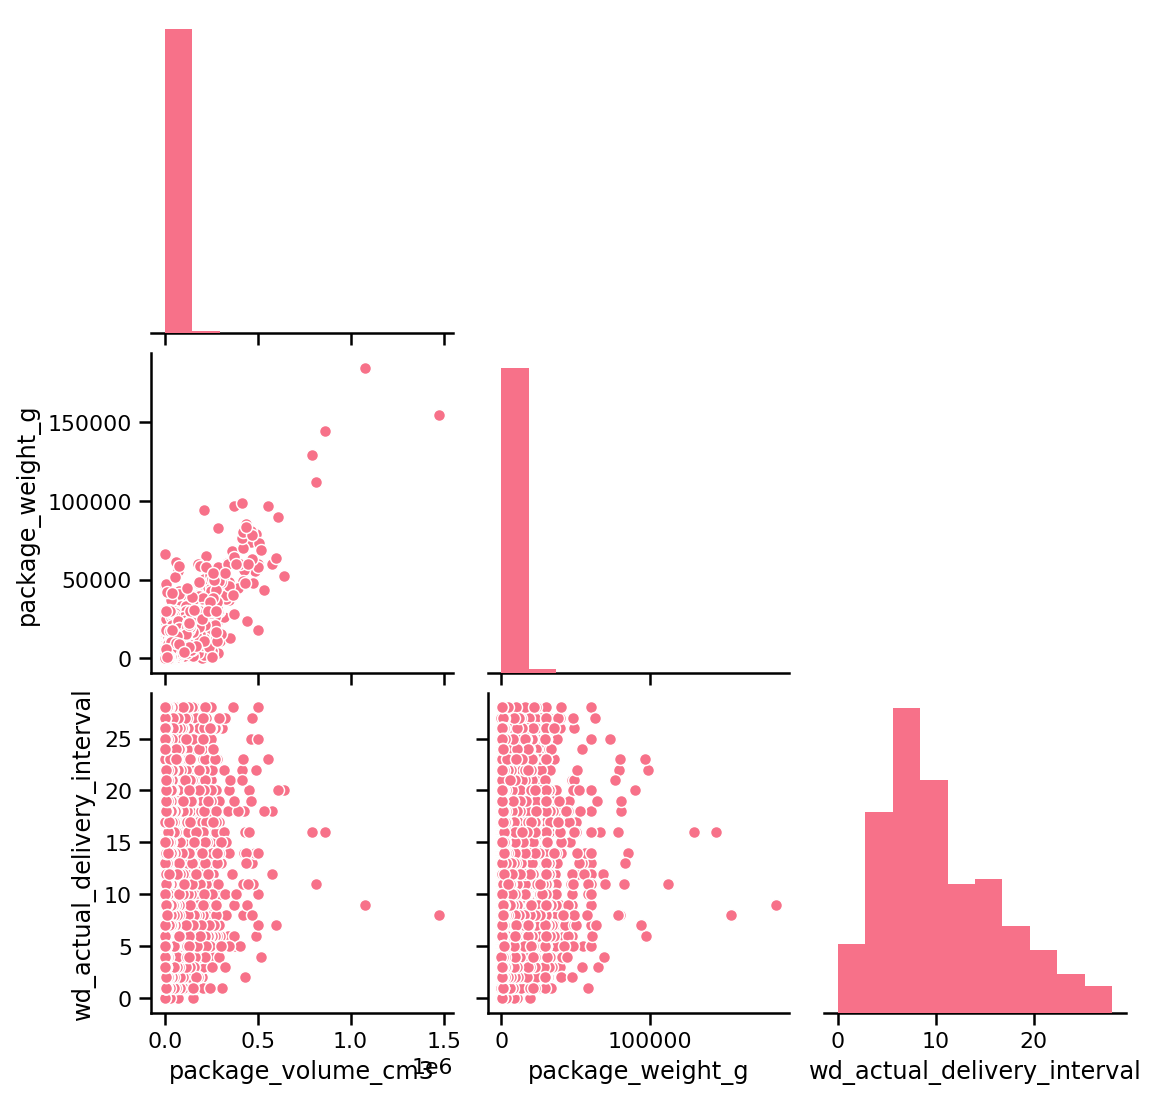

In [78]:
# Product details based

product_details_cols = [
    "package_volume_cm3",
    "package_weight_g",
    target
]

sns.pairplot(data=df, vars = product_details_cols, corner=True)

## Feature Engineering

In [79]:
new_feat = []

df['is_same_area'] = df['seller_state'] == df['customer_state']
new_feat.append("is_same_area")

<AxesSubplot:xlabel='is_same_area', ylabel='count'>

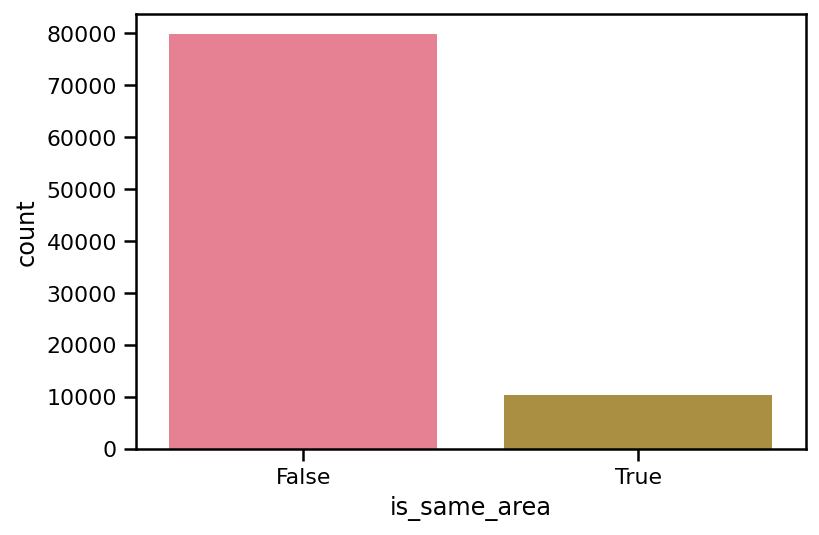

In [80]:
sns.countplot(df.is_same_area)

<AxesSubplot:xlabel='is_same_area', ylabel='wd_actual_delivery_interval'>

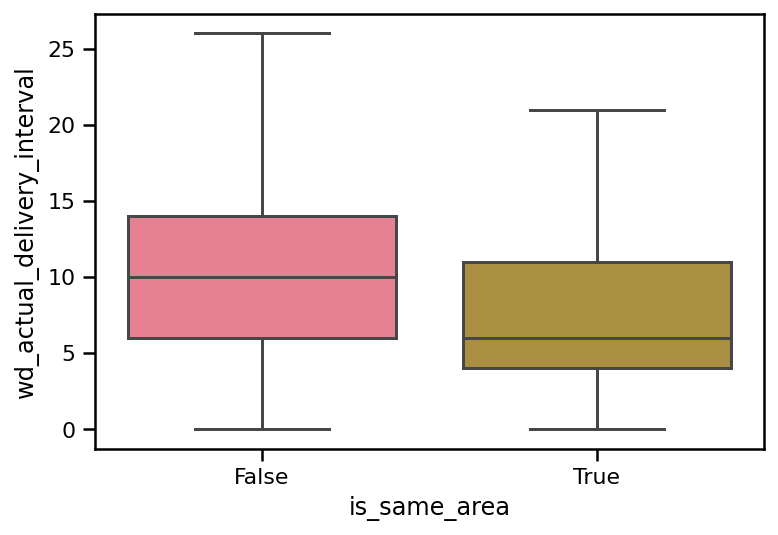

In [81]:
sns.boxplot(data=df, x="is_same_area", y="wd_actual_delivery_interval", showfliers=False)

<AxesSubplot:xlabel='total_item'>

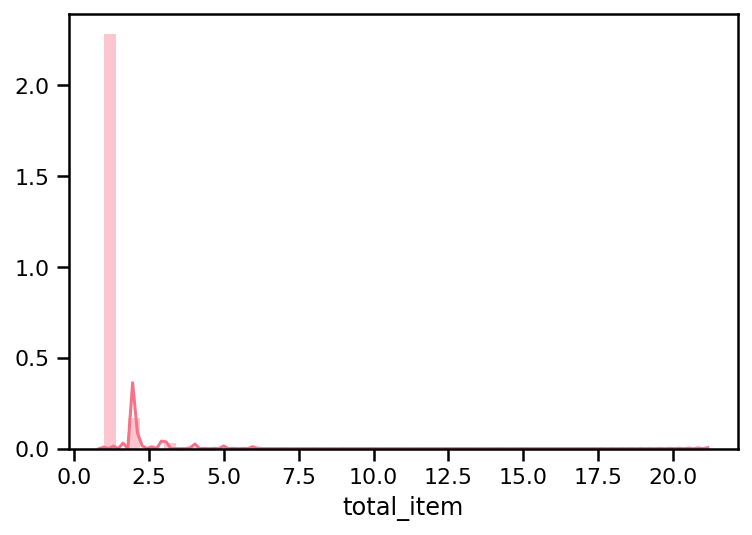

In [82]:
sns.distplot(df.total_item)

In [83]:
# === Binning ===
# df['clipped_total_item'] = df['total_item'].progress_apply(
#     lambda val : val if val <= 1 else 2
# )

<AxesSubplot:xlabel='total_item', ylabel='wd_actual_delivery_interval'>

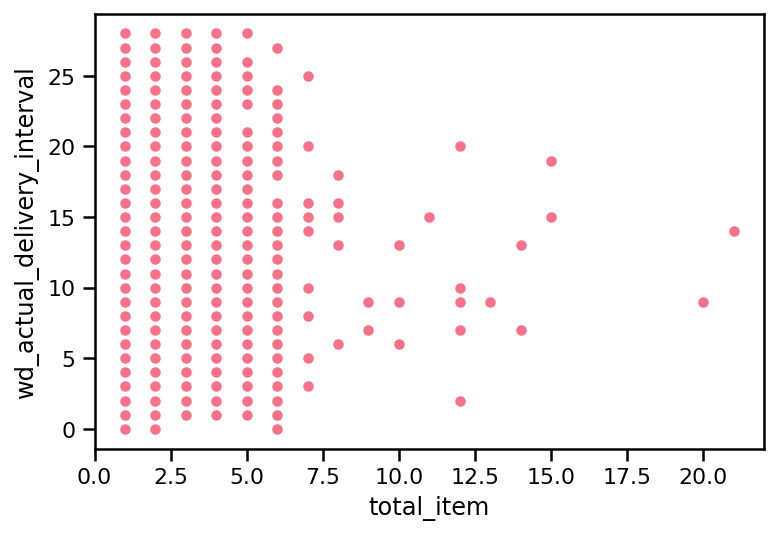

In [84]:
sns.scatterplot(data=df, x="total_item", y=target)

In [85]:
# Normalization on data
# === Log Transformation === 
df['log_shipping_cost'] = (df['shipping_cost']+1).apply(np.log)
df['log_total_price'] = df['total_price'].apply(np.log)
df['log_aov'] = df['aov'].apply(np.log)

<AxesSubplot:xlabel='shipping_cost'>

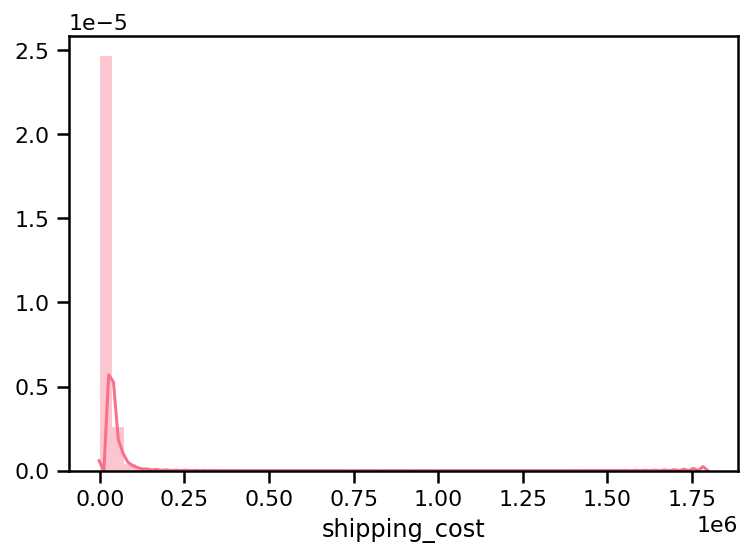

In [86]:
sns.distplot(df.shipping_cost)

<AxesSubplot:xlabel='log_shipping_cost'>

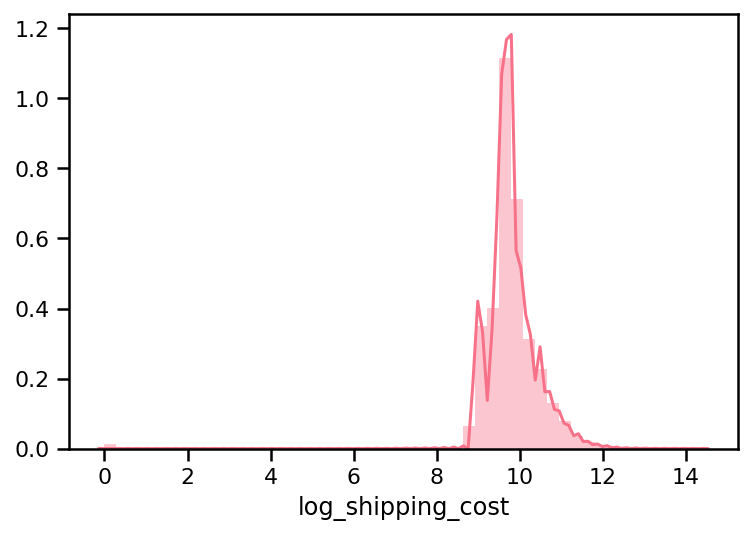

In [87]:
sns.distplot(df.log_shipping_cost)

<AxesSubplot:xlabel='log_shipping_cost', ylabel='wd_actual_delivery_interval'>

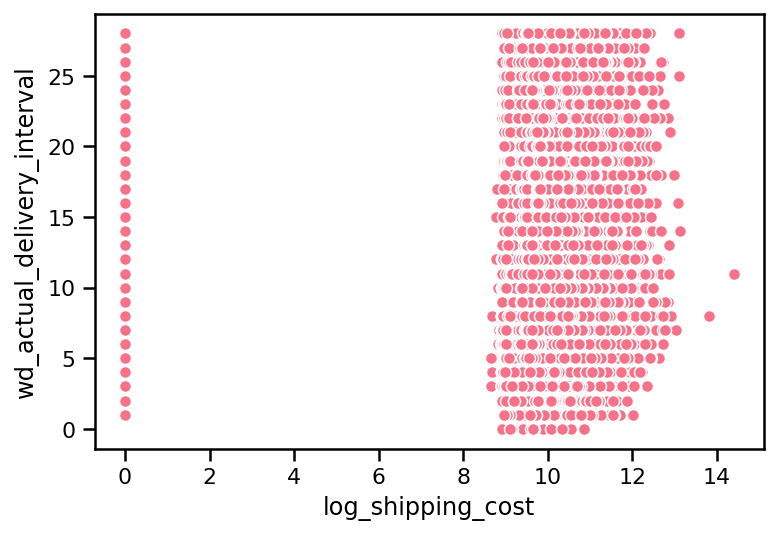

In [88]:
sns.scatterplot(data=df, x="log_shipping_cost", y=target)

<AxesSubplot:xlabel='aov'>

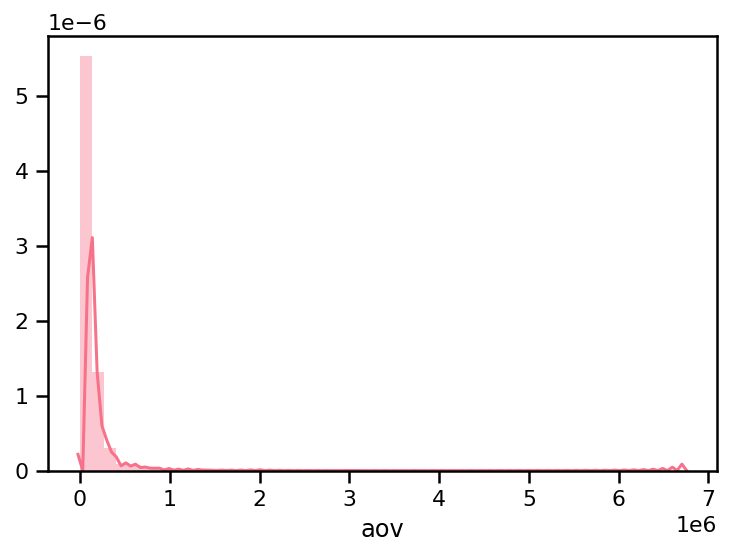

In [89]:
sns.distplot(df.aov)

<AxesSubplot:xlabel='log_aov'>

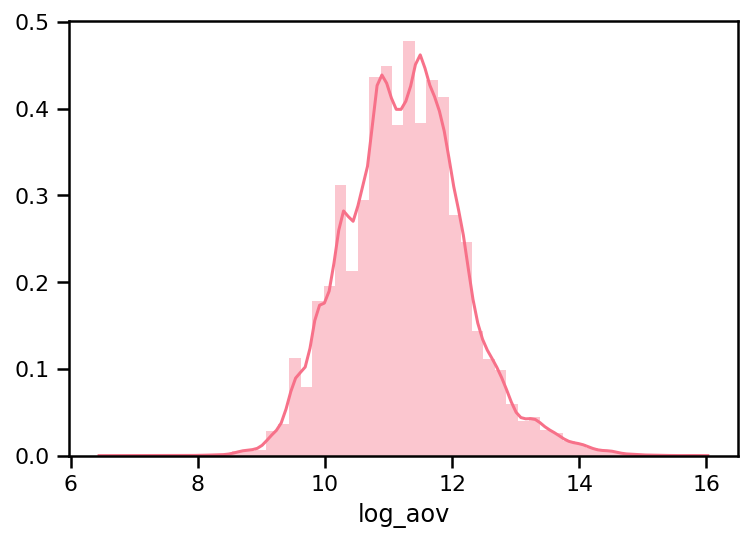

In [90]:
sns.distplot(df.log_aov)

<AxesSubplot:xlabel='log_aov', ylabel='wd_actual_delivery_interval'>

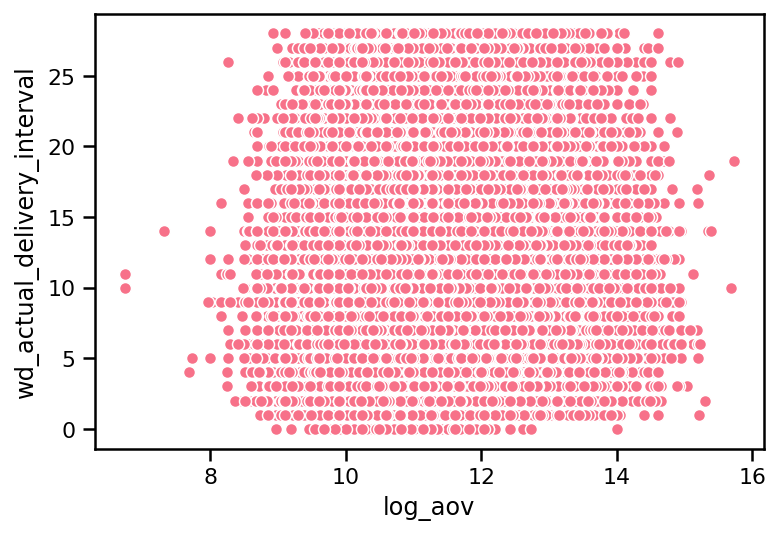

In [91]:
sns.scatterplot(data=df, x="log_aov", y=target)

<AxesSubplot:xlabel='total_price'>

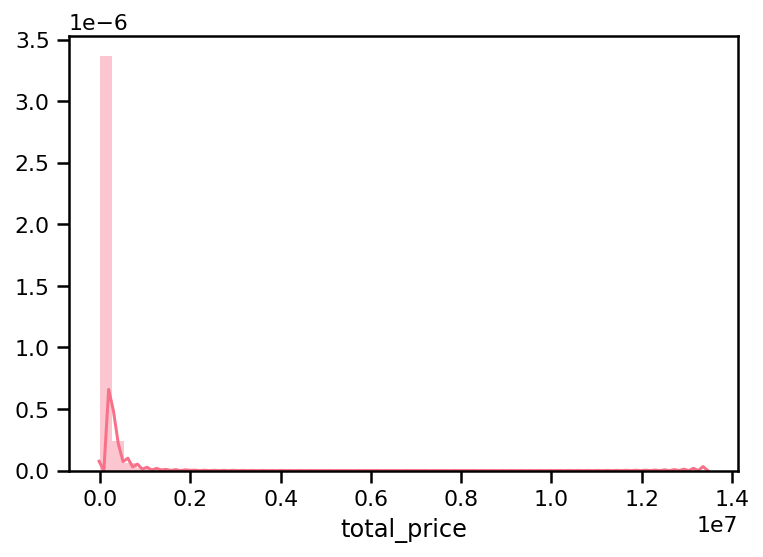

In [92]:
sns.distplot(df.total_price)

<AxesSubplot:xlabel='log_total_price'>

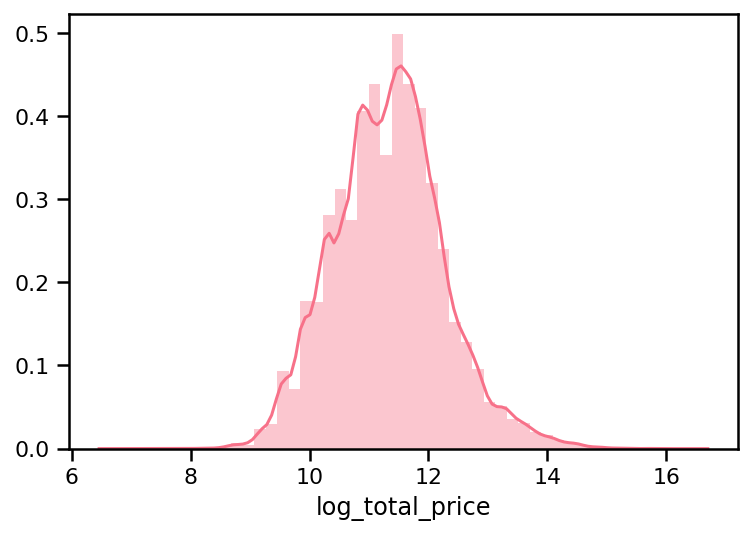

In [93]:
sns.distplot(df.log_total_price)

<AxesSubplot:xlabel='log_total_price', ylabel='wd_actual_delivery_interval'>

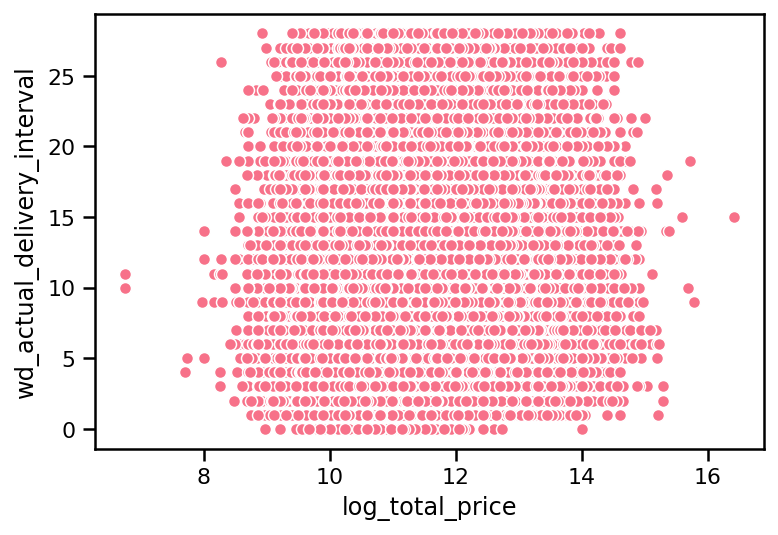

In [94]:
sns.scatterplot(data=df, x="log_total_price", y=target)

In [95]:
# === Distance Transformation ===
df['cbrt_original_distance'] = df['original_distance'].apply(np.cbrt)
df['log_pickup_distance'] = (df['pickup_distance'] + 1).apply(np.log10)
df['log_shipping_distance'] = (df['shipping_distance'] + 1).apply(np.log10)
df['log_delivering_distance'] = (df['delivering_distance'] + 1).apply(np.log10)

<AxesSubplot:xlabel='original_distance'>

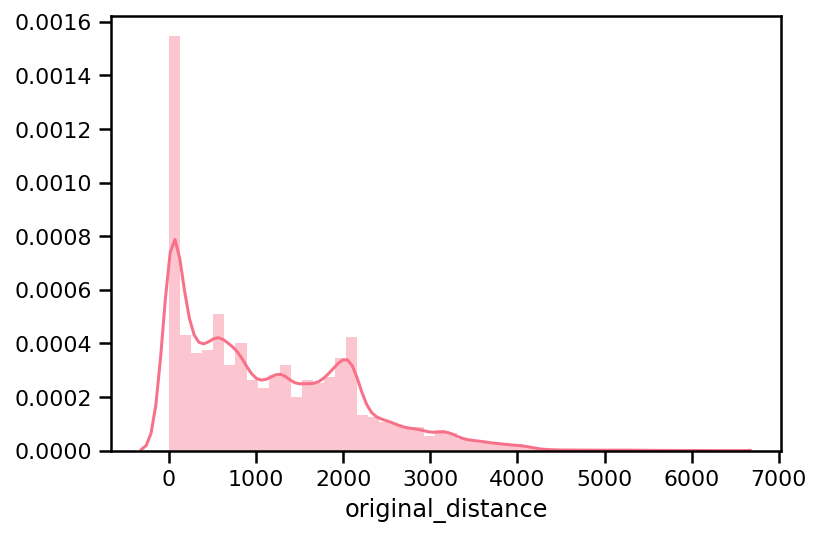

In [96]:
sns.distplot(df.original_distance)

<AxesSubplot:xlabel='cbrt_original_distance'>

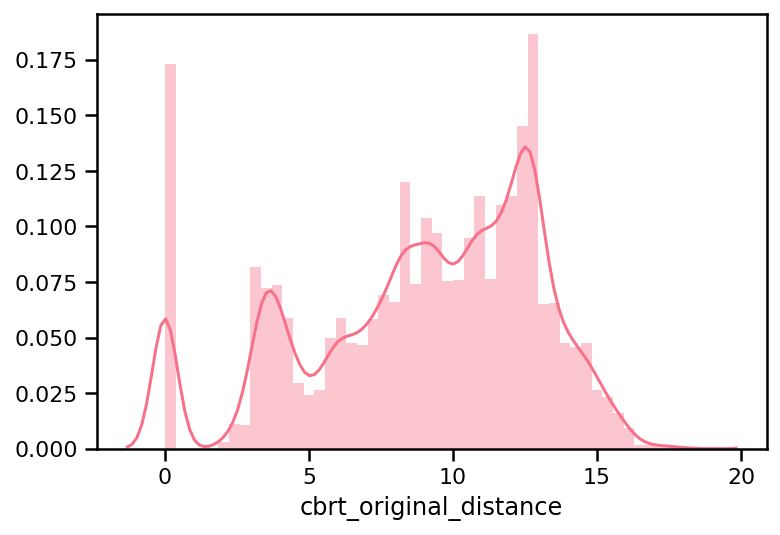

In [97]:
sns.distplot(df.cbrt_original_distance)

<AxesSubplot:xlabel='shipping_distance'>

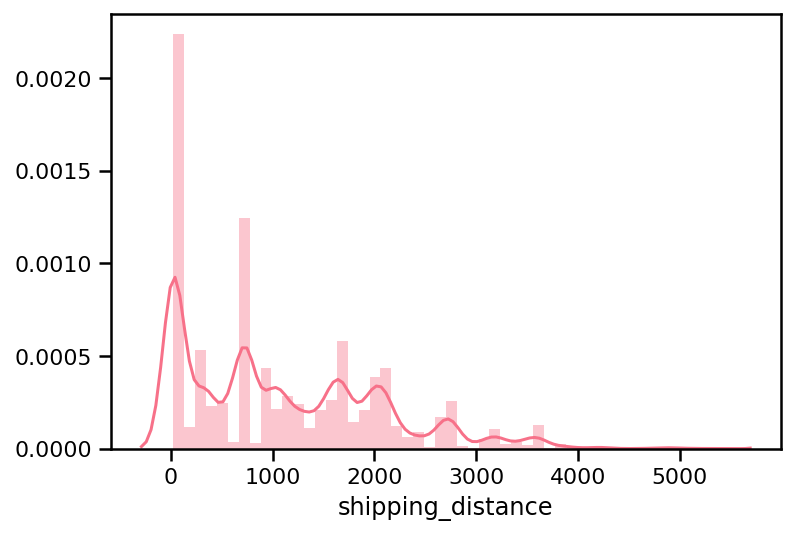

In [98]:
sns.distplot(df.shipping_distance)

<AxesSubplot:xlabel='log_shipping_distance'>

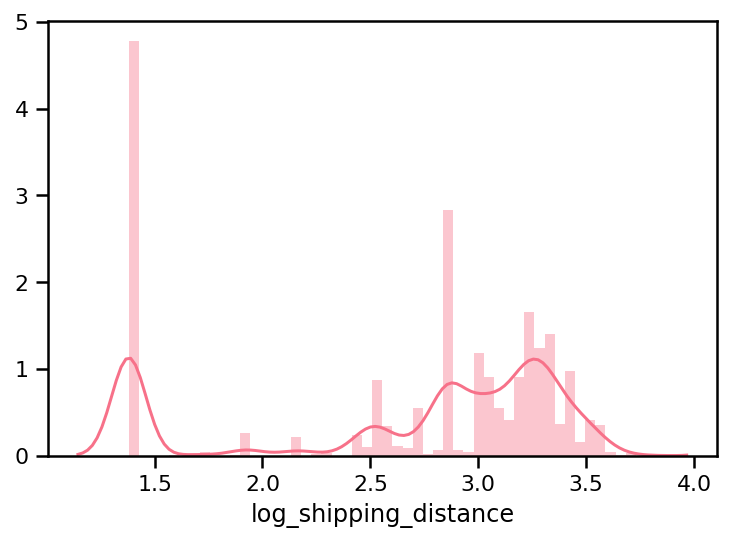

In [99]:
sns.distplot(df.log_shipping_distance)

<AxesSubplot:xlabel='pickup_distance'>

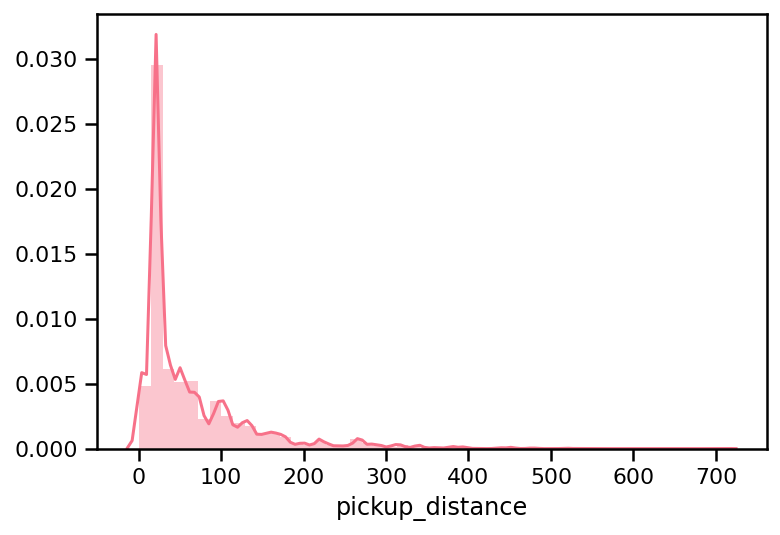

In [100]:
sns.distplot(df.pickup_distance)

<AxesSubplot:xlabel='log_pickup_distance'>

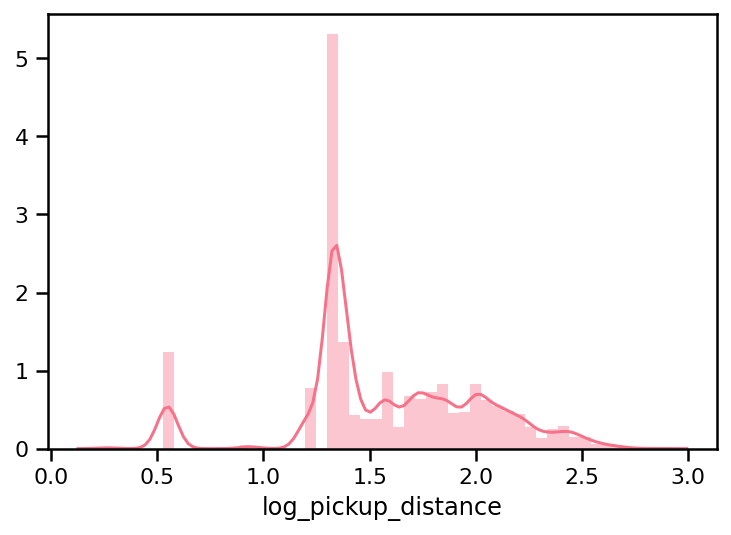

In [101]:
sns.distplot(df.log_pickup_distance)

<AxesSubplot:xlabel='delivering_distance'>

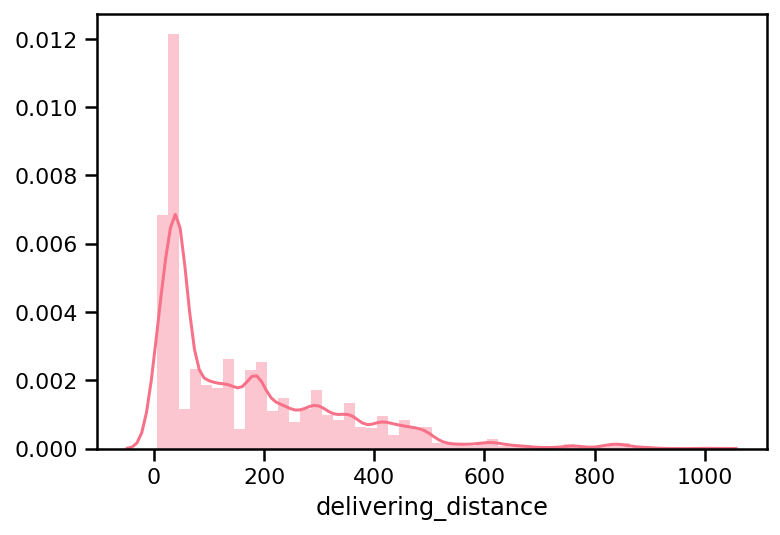

In [102]:
sns.distplot(df.delivering_distance)

<AxesSubplot:xlabel='log_delivering_distance'>

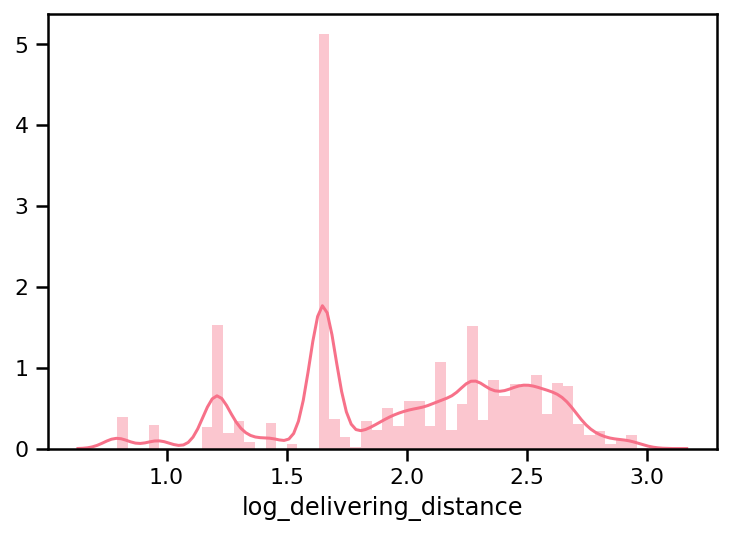

In [103]:
sns.distplot(df.log_delivering_distance)

In [104]:
# Normalization on data
# === Log Transformation === 
df['log_package_volume_cm3'] = df['package_volume_cm3'].apply(np.log)
df['log_package_weight_g'] = (df['package_weight_g'] + 1).apply(np.log)

df['log_product_volume_cm3_per_item'] = df['product_volume_cm3_per_item'].apply(np.log)
df['log_product_weight_g_per_item'] = (df['product_weight_g_per_item'] + 1).apply(np.log)

<AxesSubplot:xlabel='package_volume_cm3'>

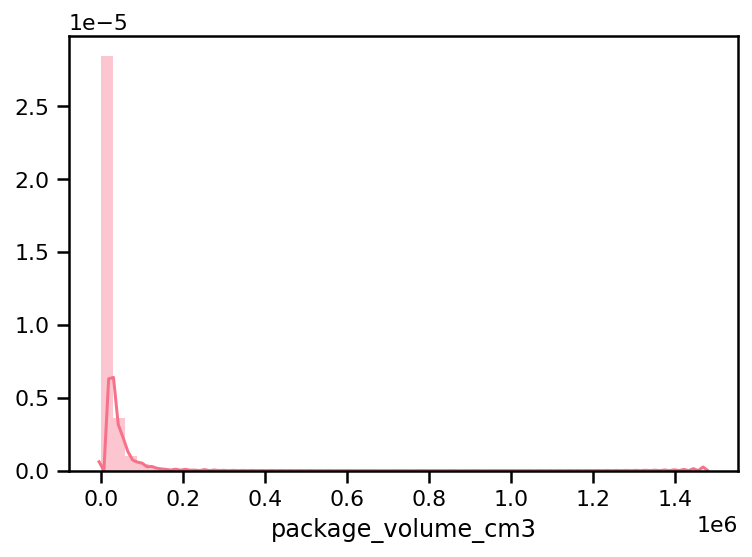

In [105]:
sns.distplot(df.package_volume_cm3)

<AxesSubplot:xlabel='log_package_volume_cm3'>

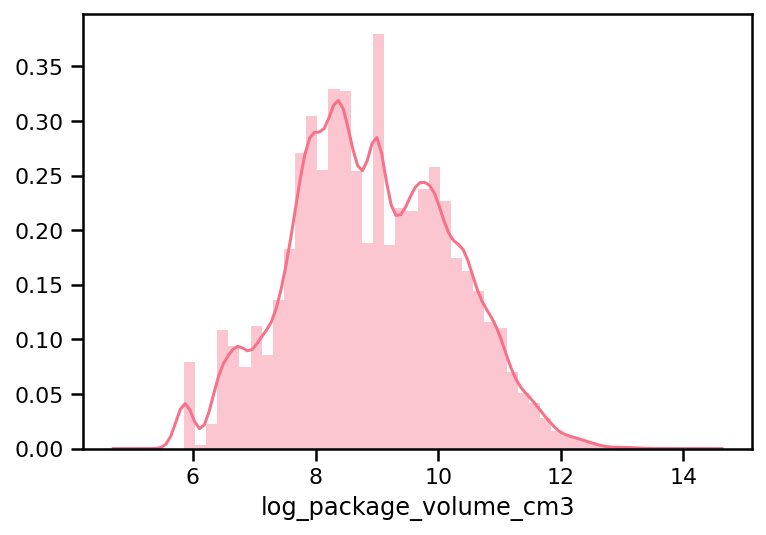

In [106]:
sns.distplot(df.log_package_volume_cm3)

<AxesSubplot:xlabel='package_weight_g'>

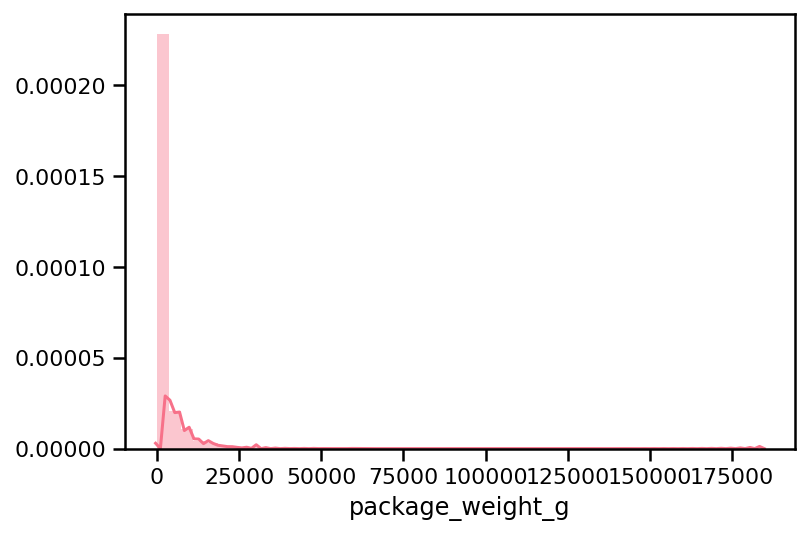

In [107]:
sns.distplot(df.package_weight_g)

<AxesSubplot:xlabel='log_package_weight_g'>

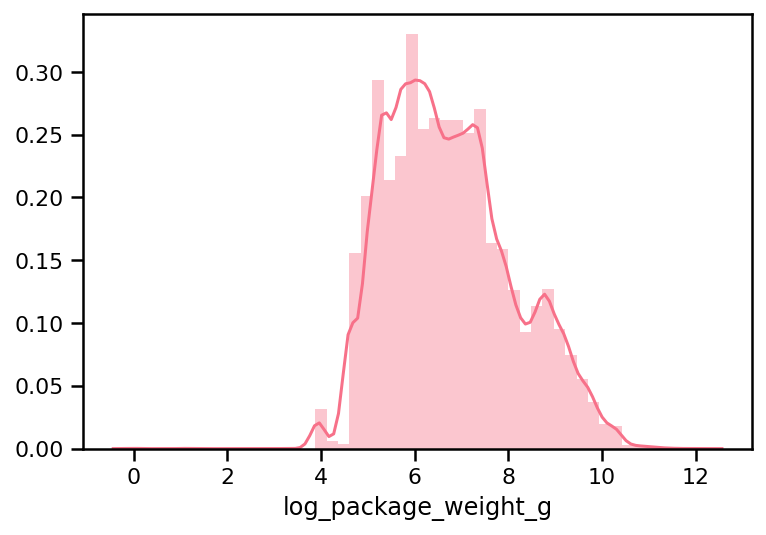

In [108]:
sns.distplot(df.log_package_weight_g)

<AxesSubplot:xlabel='product_volume_cm3_per_item'>

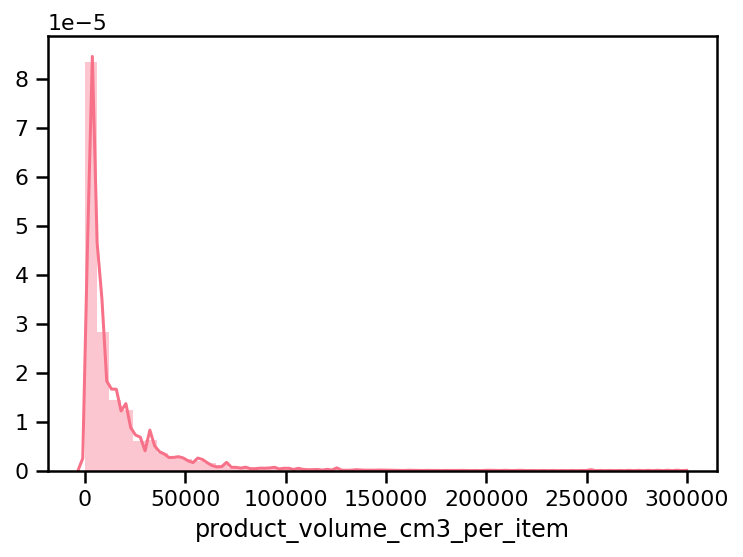

In [112]:
sns.distplot(df.product_volume_cm3_per_item)

<AxesSubplot:xlabel='log_product_volume_cm3_per_item'>

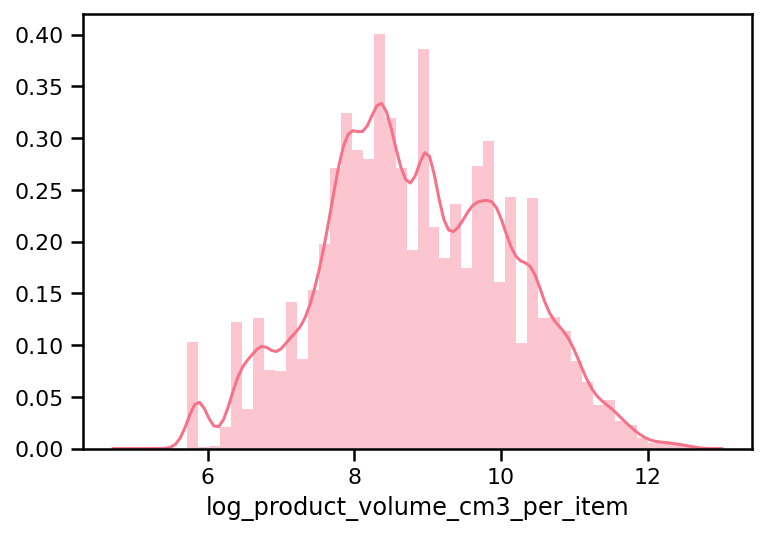

In [113]:
sns.distplot(df.log_product_volume_cm3_per_item)

<AxesSubplot:xlabel='product_weight_g_per_item'>

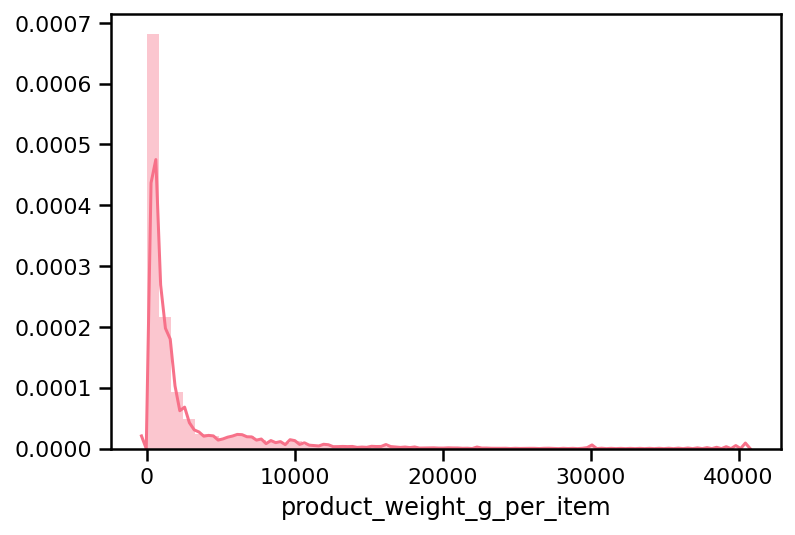

In [114]:
sns.distplot(df.product_weight_g_per_item)

<AxesSubplot:xlabel='log_product_weight_g_per_item'>

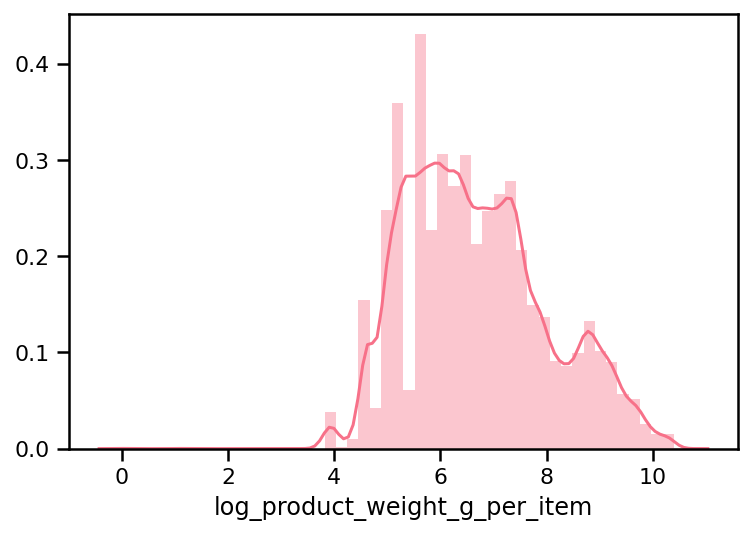

In [115]:
sns.distplot(df.log_product_weight_g_per_item)

In [109]:
# Mapping transformation cols
transformed_map = {
    # Clipping
    "total_item" : "clipped_total_item",
    
    # Logarithmic
    "shipping_cost" : "log_shipping_cost",
    "total_price" : "log_total_price",
    "aov" : "log_aov",
    "pickup_distance" : "log_pickup_distance",
    "shipping_distance" : "log_shipping_distance",
    "delivering_distance" : "log_delivering_distance",
    "package_volume_cm3" : "log_package_volume_cm3",
    "package_weight_g" : "log_package_weight_g" ,
    
    # Cube root
    "original_distance" : "cbrt_original_distance"
}

print("New Feature : ")
pprint(new_feat)
pprint(list(transformed_map.values()))

New Feature : 
['is_same_area']
['clipped_total_item',
 'log_shipping_cost',
 'log_total_price',
 'log_aov',
 'log_pickup_distance',
 'log_shipping_distance',
 'log_delivering_distance',
 'log_package_volume_cm3',
 'log_package_weight_g',
 'cbrt_original_distance']


In [110]:
# === Save Processed Data ===
location_cols = [
    "seller_city",
    "seller_state",
    "customer_city",
    "customer_state"
]

date_cols = ["order_date", "order_approved_date", "pickup_limit_date", "estimated_date_delivery", "actual_date_delivery"]
processed_df = df.drop(to_drop + list(transformed_map.keys()) + location_cols + geo_cols + date_cols, axis = 1)
# df.to_pickle("",)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

In [111]:
# === Save processed dataframe ===
# === Save Data into external file
processed_df.to_pickle("../data/processed/dataset-supervised-processed.pkl", protocol=4) # Use protocol 4 to be able to be used for python3.6